In [7]:
import time                     # Библиотека для времени
from bs4 import BeautifulSoup   # Библиотека для парсинга HTML и XML документов
from selenium import webdriver  # Фрэймворк для автоматизации работы браузеров и тестирования веб-приложений
import json


def create_browser(webdriver_path: str):
    """
        Создает и возвращает экземпляр браузера

        webdriver_path: str Путь к драйверу Chrome
    """
    #create a selenium object that mimics the browser
    #headless tag created an invisible browser
    options = webdriver.ChromeOptions()
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-notifications')
    options.add_argument('--incognito')
    options.add_argument('--disable-extensions')
    options.add_argument('--disable-dev-shm-usage')
    options.add_experimental_option(
        "prefs",
        {
            'profile.managed_default_content_settings.images': 2,
            'profile.managed_default_content_settings.javascript': 0
        }
    )
    browser = webdriver.Chrome(service=webdriver.ChromeService(webdriver_path), options=options)
    return browser


def getFilmPageLinks(page_number: int) -> list[str]:
    """
        Возвращает список ссылок на фильмы, полученный с текущей страницы

        page_number: int номер страницы для парсинга
    """
    # составляем ссылку на страницу поиска
    global url
    # url_lists = 'https://www.kinopoisk.ru/lists/movies/?b=films'
    url_lists = f'{url}/lists/movies/?b=films'
    page_link = f'{url_lists}&page={page_number}'

    # получаем содержимое страницы и переводим в суп
    global browser
    # browser = create_browser(driver_path)
    browser.get(page_link)
    time.sleep(1)  # Пауза на 1 секунду для того, чтобы не забанили на сервер
    page_html = browser.page_source

    soup = BeautifulSoup(page_html, 'html.parser')
    all_link_tags = soup.find_all(lambda tag: tag.name == 'a' and tag.get('class') == ['styles_root__wgbNq'])
    page_links = [url + link.attrs['href'] for link in all_link_tags]

    return page_links


def getStats(soup) -> dict:
    """
        Считывает данные со страницы, заданной soap
    """
    # get main part with main info (we assume it is always given)
    product_main = soup.find(lambda tag: tag.name == 'div' and tag.get('class') == ['styles_column__r2MWX',
                                                                                    'styles_md_17__FaWtp',
                                                                                    'styles_lg_21__YjFTk',
                                                                                    'styles_column__5dEFP'])
    if product_main:
        #####################################
        #  get FILM NAME from main section  #
        #####################################
        name = product_main.find('h1').text.split('(')[0].strip()

        ################
        #  get RATING  #
        ################
        rating_element = product_main.find_all(lambda tag: tag.name == 'span' and tag.get('class') is not None and 'film-rating-value' in tag.get('class'))
        rating = 'unknown'
        if rating_element:
            rating = rating_element[0].find('span').text.strip()

        ###################
        #  get countries  #
        ###################
        countries_element = product_main.find(lambda tag: tag.name == 'div' and tag.get('data-test-id') == 'countries')
        countries = [element.text.strip() for element in countries_element.find_all('a') if element.attrs.get('data-tid') == '603f73a4']

        ############################
        #  get Year of production  #
        ############################
        year_prod_element = product_main.find(lambda tag: tag.name == 'div' and tag.get('data-test-id') == 'year')
        year_prod = year_prod_element.find('a').text.strip()

        ################
        #  get Genres  #
        ################
        genres_prod_element = product_main.find(lambda tag: tag.name == 'div' and tag.get('data-test-id') == 'genres')
        genres_prod = [element.text.strip() for element in genres_prod_element.find_all('a') if element.attrs.get('data-tid') == '603f73a4']

        ################
        #  get Budget  #
        ################
        budget_prod_element = product_main.find(lambda tag: tag.name == 'div' and tag.get('data-test-id') == 'budget')
        budget_prod = 'unknown'
        if budget_prod_element:
            budget_prod = budget_prod_element.find('a').text.strip()
            budget_prod = ''.join(budget_prod.split())

        ##################
        #  get worldBox  #
        ##################
        worldbox_prod_element = product_main.find(lambda tag: tag.name == 'div' and (tag.get('data-test-id') == 'worldBox' or tag.get('data-test-id') == 'rusBox'))
        worldbox_prod = 'unknown'
        if worldbox_prod_element:
            worldbox_prod_l = worldbox_prod_element.find('a').text.strip().split('=')
            worldbox_prod = ''.join(worldbox_prod_l[-1].split())


        ########################
        #  get ageRestriction  #
        ########################
        age_restriction_prod_element = product_main.find(lambda tag: tag.name == 'div' and tag.get('data-test-id') == 'ageRestriction')
        age_restriction_prod = 'unknown'
        if age_restriction_prod_element:
            age_restriction_prod = age_restriction_prod_element.find('a').text.strip()

        # collect and return results
        return {
            "name": name,
            "rating": rating,
            "countries": countries,
            "year": year_prod,
            "budget": budget_prod,
            "world_box": worldbox_prod,
            "age_restriction": age_restriction_prod,
            "genres": genres_prod,
        }
    else:
        return {
            "name": 'unknown',
            "rating": 'unknown',
            "countries": 'unknown',
            "year": 'unknown',
            "budget": 'unknown',
            "world_box": 'unknown',
            "age_restriction": 'unknown',
            "genres": 'unknown',
        }



driver_path = './chromedriver'
browser = create_browser(driver_path)
url = 'https://www.kinopoisk.ru'

film_links = []
page_number = 1
num_subsequent_errors = 0

while page_number <= 500:
    if page_number % 5 == 0:
        print(f'processing page {page_number} ...')
    # Attempt to get film links from the current page
    film_links_from_current_page = getFilmPageLinks(page_number=page_number)
    if film_links_from_current_page != []:
        film_links.extend(film_links_from_current_page)
        # Reset error counter since this page was successfully read
        num_subsequent_errors = 0
        # Increment to the next page
        page_number += 1
    else:
        print(f'Page {page_number} could not be read or it does not exist!')
        # Increment error counter
        num_subsequent_errors += 1
        page_number += 1  # Still increment page number to move forward

        # Stop if 3 errors in a row occur
        if num_subsequent_errors == 3:
            print("Stopping due to 3 consecutive errors.")
            break


result_films = []
for link in film_links:
    browser.get(link)
    time.sleep(1)  # Пауза на 1 секунду для того, чтобы не забанили на сервер
    page_html = browser.page_source

    soup = BeautifulSoup(page_html, 'html.parser')
    result = getStats(soup)
    result['film_url'] = link
    result_films.append(result)

browser.close()

# print(*film_links, sep='\n')
print(len(film_links))
with open('result_films.json', 'a', encoding='utf-8') as f:
    json.dump(result_films, f, ensure_ascii=False, indent=4)
# print(result_films)

processing page 405 ...
processing page 410 ...
processing page 415 ...
processing page 420 ...
processing page 425 ...
processing page 430 ...
processing page 435 ...
processing page 440 ...
processing page 445 ...
processing page 450 ...
processing page 455 ...
processing page 460 ...
processing page 465 ...
processing page 470 ...
processing page 475 ...
processing page 480 ...
processing page 485 ...
processing page 490 ...
processing page 495 ...
processing page 500 ...
5000


final_df.shape показывает, сколько признаков (столбцов) и наблюдений (строк) содержится в наборе данных.
(25000, 9)

info() облегчает понимание типа данных и связанной с ним информации, такой как количество записей в каждом столбце, наличие или отсутствие нулевых значений, тип данных и использование памяти для набора данных.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Name             25000 non-null  object
 1   Rating           25000 non-null  object
 2   Countries        25000 non-null  object
 3   Year             25000 non-null  object
 4   Budget           25000 non-null  object
 5   World box        25000 non-null  object
 6   Age restriction  25000 non-null  object
 7   Genres           25000 non-null  object
 8   Film url         25000 non-null  object
dtypes: object(9)
memory usage: 1.7+ MB

Проверка пропущенных значений

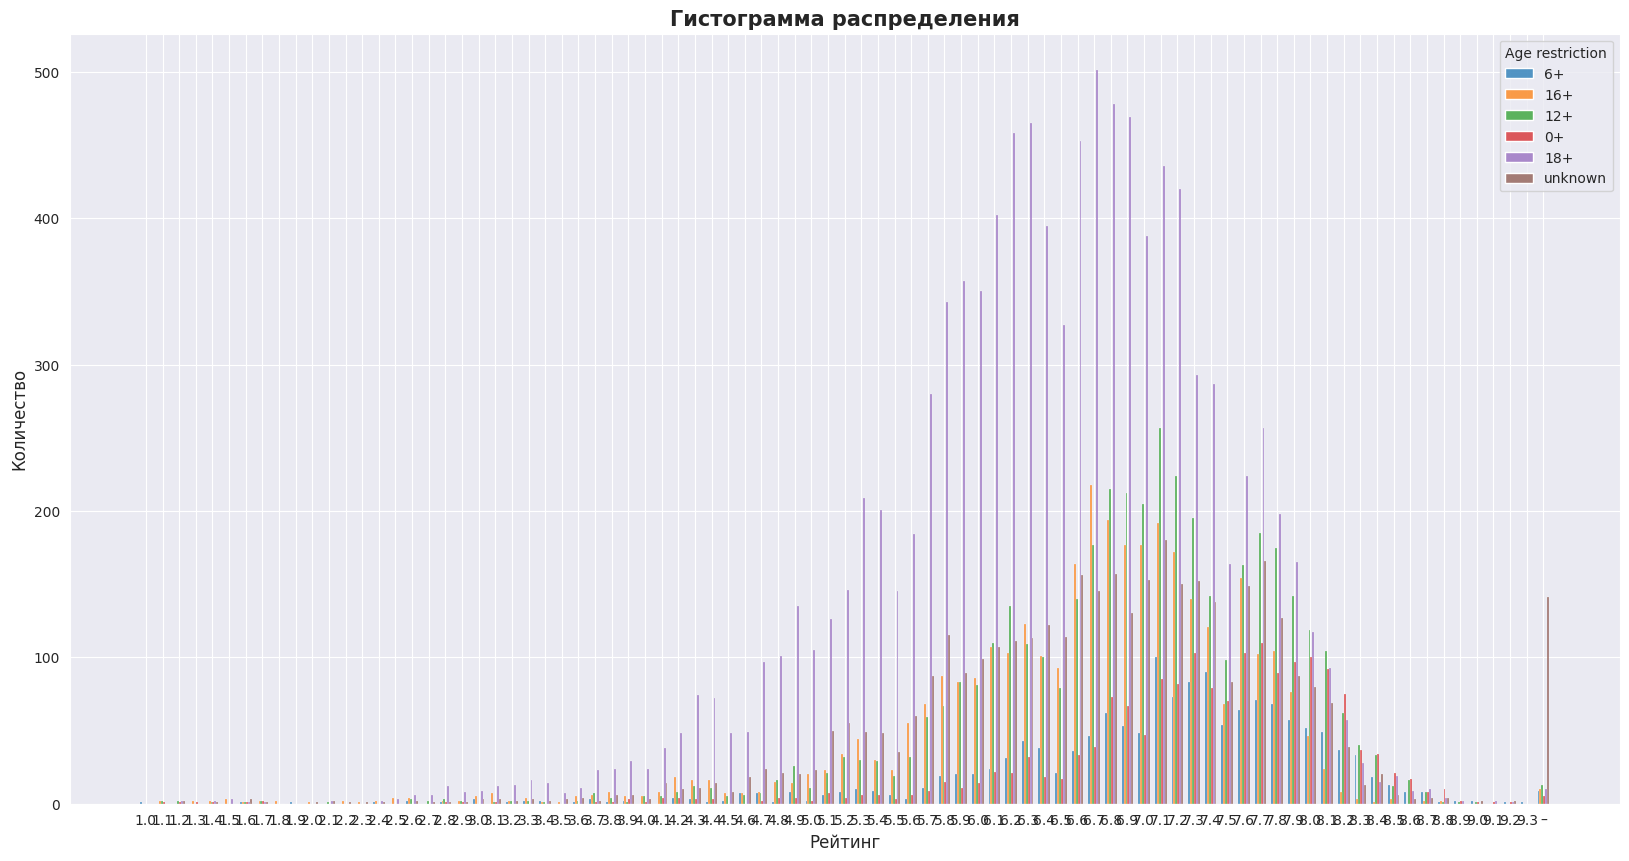

In [14]:
import pandas as pd             # Библиотека для табличек
import matplotlib.pyplot as plt # Библиотека для визуализации данных
import seaborn as sns           # Библиотека для визуализации данных
import json

with open('result_films.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

final_df = pd.DataFrame(data)
final_df.columns = ['Name', 'Rating', 'Countries', 'Year', 'Budget', 'World box', 'Age restriction', 'Genres',
                    'Film url']
# final_df = final_df.drop_duplicates().dropna(axis = 1)

print('final_df.shape показывает, сколько признаков (столбцов) и наблюдений (строк) содержится в наборе данных.')
print(final_df.shape)
print()

print('info() облегчает понимание типа данных и связанной с ним информации, такой как количество записей в каждом столбце, наличие или отсутствие нулевых значений, тип данных и использование памяти для набора данных.')
final_df.info()
print()

print('Проверка пропущенных значений')
print(final_df.isnull().sum())
print()

print('Проверка на наличие повторяющихся значений')
print(final_df['Name'].nunique())
print()

# print('Возвращает статистическую сводку по столбцам DataFrame')
# final_df.describe()

# final_df

index_names = final_df[ final_df['Rating'] == 'unknown' ].index
final_df.drop(index_names, inplace = True)
final_df = final_df.sort_values('Rating')

plt.figure(figsize=(20, 10))  # создаем "фон" для картинок
plt.title('Гистограмма распределения', size=15, weight='bold')  # название
sns.histplot(
    data=final_df, # по каким данным будет визуализация
    x='Rating', # какой столбец исследуется
    hue='Age restriction', # по какому столбцу разбиваем на группы
    multiple="dodge", # хотим не в нахлест столбцы, а рядом друг с другом
    shrink=.7 # сужаем столбцы
)  # сам график
plt.xlabel('Рейтинг', size=12)  # название оси Х
plt.ylabel('Количество', size=12)  # название оси Y
plt.show()
